In [1]:
#packages import
import os
os.chdir('..')  #cd to PiperNET folder

from pathlib import Path
from src.rnaseq_utils import get_config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

#matplotlib settings
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
colors = sns.color_palette('colorblind')

In [2]:
### Data import ###

#proteomes
config_path = Path('config/rnaseq_dataprep.yaml')
proteome_list = get_config(config_path, data='proteome_csv')

for sample, path in proteome_list.items():
        proteome_list[sample] = pd.read_csv(path) #update proteome_list with dfs


#unique df with all proteomes
proteomes_all = pd.DataFrame()
for sample, proteome in proteome_list.items(): #iterate over each proteome in proteome_list
    proteome['sample'] = sample #add 'sample' column with sample name (e.g., piepr09)
    proteome.columns = [col.split('_', 1)[1] if 'rep' in col else col for col in proteome.columns] #remove sample name from tpm cols
    proteomes_all = pd.concat([proteomes_all, proteome], ignore_index=True) #concat df

proteomes_all.set_index('id', inplace=True) #'id' col as index

#species names
species_names = get_config(config_path, data='species')
species_names = {k: str(v) for k, v in species_names.items()}

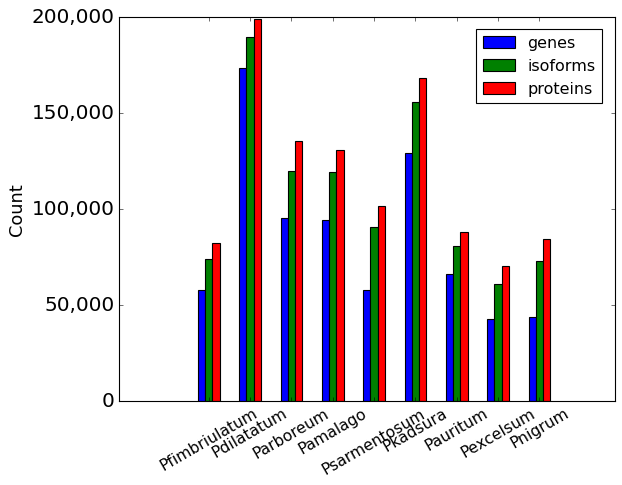

In [57]:

#PLOT
data = pd.DataFrame(columns=['genes', 'isoforms', 'proteins'])

for species in proteomes_all['sample'].unique():
    proteome = proteomes_all[(proteomes_all['sample'] == species)] #select sample
    
    #count unigenes, isoforms, proteins
    unigenes = (proteome.index.to_series().str.split('_', n=2).str[1]).unique()
    isoforms = (proteome.index.to_series().str.split('.', n=2).str[0]).unique()
    proteins = (proteome.index.to_series()).unique()

    summary = pd.DataFrame({'genes': [len(unigenes)], 'isoforms': [len(isoforms)], 'proteins': [len(proteins)]}, index=[species])
    data = pd.concat([data, summary], axis=0)

# Change X labels according to the dictionary
data.index = data.index.map(species_names)

#plot
fig, axs = plt.subplots()
width = 0.175
bargroups = data.shape[0]
series = data.shape[1]
x_pos = np.arange(bargroups).astype(float)

for series in range(series):
    axs.bar(x_pos, data.iloc[:,series], width, label=data.columns[series])
    x_pos += width




#axsis labels
axs.set_ylabel('Count', fontdict={'fontsize': '16'})
axs.set_xticks(np.arange(bargroups) + width, data.index)
axs.set_xticklabels(data.index, fontdict={'fontsize': '14'}, rotation=30)

# Format y-axis labels
axs.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axs.tick_params(axis='y', labelsize='18')

#legend
axs.legend(bbox_to_anchor=(0.99, 0.99))

#show and save
plt.show()

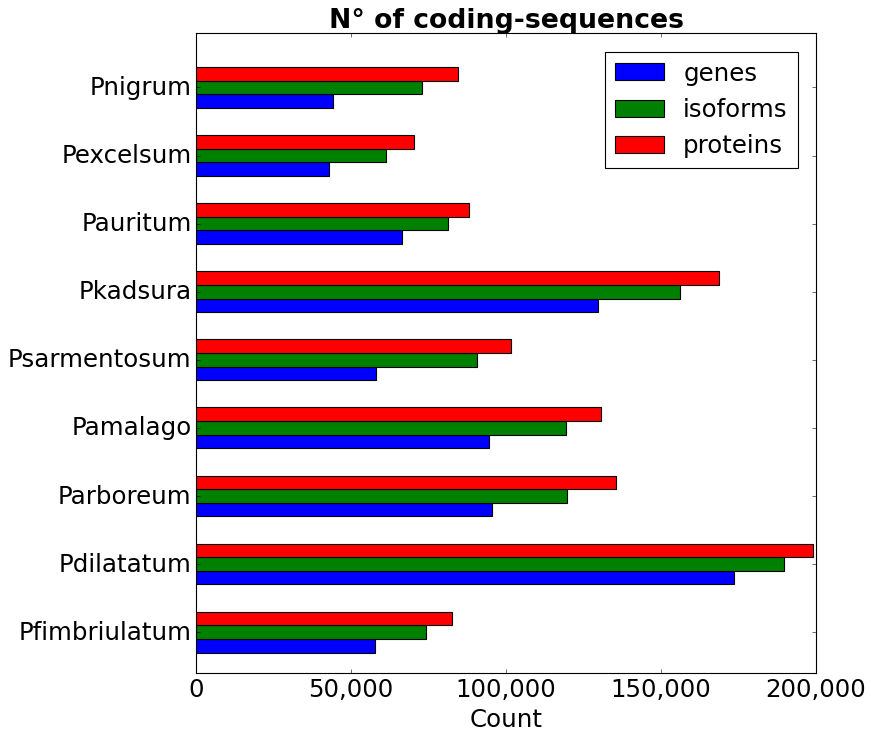

In [90]:
#plot
fig, axs = plt.subplots(figsize=(10, 10))
height = 0.2
bargroups = data.shape[0]
series = data.shape[1]
y_pos = np.arange(bargroups).astype(float)

for series in range(series):
    axs.barh(y_pos, data.iloc[:,series], height, label=data.columns[series])
    y_pos += height

#X-axis labels
axs.set_xlabel('Count', fontdict={'fontsize': '22'})
axs.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
axs.tick_params(axis='x', labelsize='22')

#Y-axis labels
axs.set_yticks(np.arange(bargroups) + height)
axs.set_yticklabels(data.index, fontdict={'fontsize': '22'})

# Adjust y-axis limits
axs.set_ylim([-0.4, bargroups])  # Adjust the lower limit to 0

#title
axs.set_title('N° of coding-sequences', fontdict={'fontsize': '24', 'fontweight': 'bold'})

#legend
axs.legend(bbox_to_anchor=(0.99, 0.99), prop={'size': 22})

#show and save
plt.show()

In [ ]:
### Data import ###

#sonicparanoid
sonicpd = pd.read_csv('data/rna-seq/orthologs/runs/piperNET/ortholog_groups/ortholog_groups.tsv', sep='\t', index_col='group_id')
sonicpd = sonicpd.applymap(lambda x: x.split(',') if isinstance(x, str) else x) #turn entrie into lists (instead of strings)
sonicpd = sonicpd.applymap(lambda x: [] if x == ['*'] else x) #replace empty entries with None instead of '*' 
sonicpd.columns = [col.split('.')[0] for col in sonicpd.columns] #remove .pep from col names
orths = sonicpd.loc[:, [col for col in sonicpd.columns if 'piper' in col]] #keep only OGs columns


#proteomes
config = Path('config/rnaseq_dataprep.yaml')
proteome_list = get_config(config, data='proteome_csv')

for sample, path in proteome_list.items():
        proteome_list[sample] = pd.read_csv(path) #update dfs as proteome_list values

#unique df with all proteomes
proteomes_all = pd.DataFrame()
for sample, proteome in proteome_list.items(): #iterate over each proteome in proteome_list
    proteome['sample'] = sample #add 'sample' column with sample name (e.g., piepr09)
    proteome.columns = [col.split('_', 1)[1] if 'rep' in col else col for col in proteome.columns] #remove sample name from tpm cols
    proteomes_all = pd.concat([proteomes_all, proteome], ignore_index=True) #concat df

proteomes_all.set_index('id', inplace=True) #'id' col as index


#prefixes
prefixes = get_config(config, data='prefix')
prefixes = {key: str(val) for key, val in prefixes.items()} #convert Path to str 

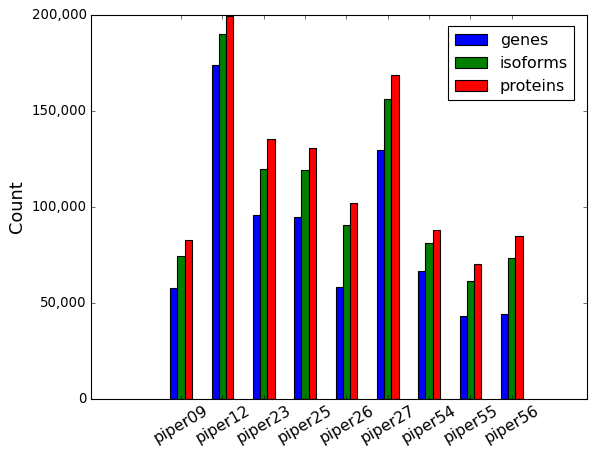

In [43]:
### Genes, isoforms, proteins ###
data = pd.DataFrame(columns=['genes', 'isoforms', 'proteins'])

for species, proteome in proteome_list.items():
    unigenes = (proteome['id'].str.split('_', n=2).str[1]).unique()
    isoforms = proteome['id'].str.split('.', n=1).str[0].unique()
    proteins = proteome['id'].unique()
    summary = pd.DataFrame({'genes': [len(unigenes)], 'isoforms': [len(isoforms)], 'proteins': [len(proteins)]}, index=[species])
    data = pd.concat([data, summary], axis=0)


#plot
fig, axs = plt.subplots()
width = 0.175
bargroups = data.shape[0]
series = data.shape[1]
x_pos = np.arange(bargroups).astype(float)

for series in range(series):
    axs.bar(x_pos, data.iloc[:,series], width, label=data.columns[series])
    x_pos += width

#axsis labels
axs.set_ylabel('Count', fontdict={'fontsize': '16'})
axs.set_xticks(np.arange(bargroups) + width, data.index)
axs.set_xticklabels(proteome_list.keys(), fontdict={'fontsize': '14'}, rotation=30)

# Format y-axis labels
axs.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))


#legend
axs.legend(bbox_to_anchor=(0.99, 0.99))

#show and save
plt.show()

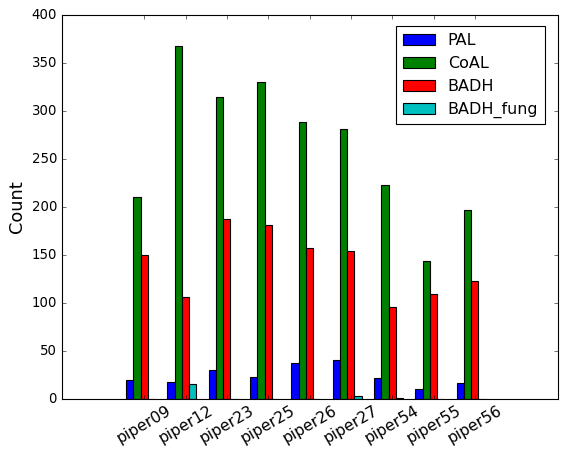

In [30]:
### BAHDs ###

#Pfam domains
pfams = {'PAL': 'PF00221',
        'CoAL':'PF00501',
        'BADH': 'PF02458',
        'BADH_fung': 'PF05141'}

#domain count
data = pd.DataFrame(dtype='float64')

for species, proteome in proteome_list.items():
    pfam_count = pd.Series(name=species, dtype='float64') #empty series

    for domain, enzyme in zip(pfams.values(), pfams.keys()): 
        count = proteome.loc[:,'pfam'].str.contains(domain).sum()
        pfam_count.at[enzyme] = count

    data = pd.concat([data, pfam_count], axis=1)

data = data.T


#plot
fig, axs = plt.subplots()
width = 0.175
bargroups = data.shape[0]
series = data.shape[1]
x_pos = np.arange(bargroups).astype(float)

for n in range(series):
    axs.bar((x_pos - (width * (series/2))), data.iloc[:,n], width, label=data.columns[n])
    x_pos += width


#axsis labels
axs.set_ylabel('Count', fontdict={'fontsize': '16'})
axs.set_xticks(np.arange(bargroups), data.index)
axs.set_xticklabels(proteome_list.keys(), fontdict={'fontsize': '14'}, rotation=30)

#legend
axs.legend(bbox_to_anchor=(0.99, 0.99))

#show and save
plt.show()

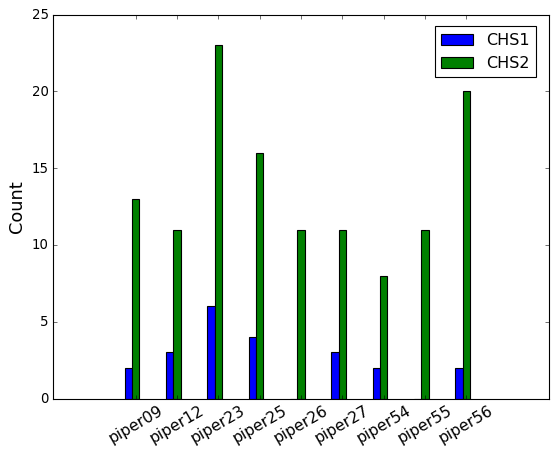

In [31]:
### PKSs ###
pfams = {'CHS1': 'PF02797',
         'CHS2': 'PF00195'}


#domain count
data = pd.DataFrame(dtype='float64')

for species, proteome in proteome_list.items():
    pfam_count = pd.Series(name=species, dtype='float64') #empty series

    for domain, enzyme in zip(pfams.values(), pfams.keys()): 
        count = proteome.loc[:,'pfam'].str.contains(domain).sum()
        pfam_count.at[enzyme] = count

    data = pd.concat([data, pfam_count], axis=1)

data = data.T


#plot
fig, axs = plt.subplots()
width = 0.175
bargroups = data.shape[0]
series = data.shape[1]
x_pos = np.arange(bargroups).astype(float)

for n in range(series):
    axs.bar((x_pos - (width * (series/2))), data.iloc[:,n], width, label=data.columns[n])
    x_pos += width


#axsis labels
axs.set_ylabel('Count', fontdict={'fontsize': '16'})
axs.set_xticks(np.arange(bargroups), data.index)
axs.set_xticklabels(proteome_list.keys(), fontdict={'fontsize': '14'}, rotation=30)

#legend
axs.legend(bbox_to_anchor=(0.99, 0.99))

#show and save
plt.show()

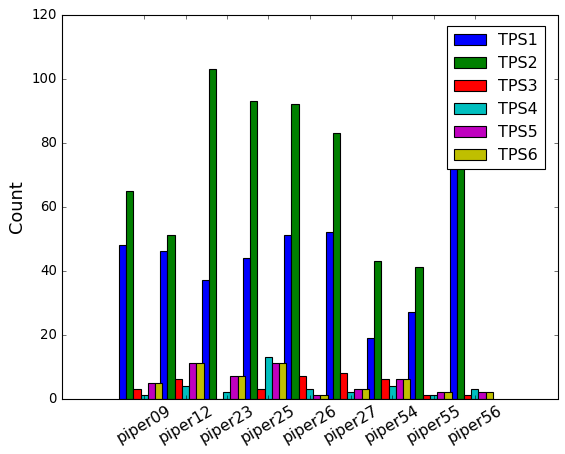

In [32]:
### TPSs ###
pfams = {'TPS1': 'PF01397',
         'TPS2': 'PF03936',
         'TPS3': 'PF19086',
         'TPS4': 'PF13249',
         'TPS5': 'PF13243',
         'TPS6': 'PF13243',}

#domain count
data = pd.DataFrame(dtype='float64')

for species, proteome in proteome_list.items():
    pfam_count = pd.Series(name=species, dtype='float64') #empty series

    for domain, enzyme in zip(pfams.values(), pfams.keys()): 
        count = proteome.loc[:,'pfam'].str.contains(domain).sum()
        pfam_count.at[enzyme] = count

    data = pd.concat([data, pfam_count], axis=1)

data = data.T


#plot
fig, axs = plt.subplots()
width = 0.175
bargroups = data.shape[0]
series = data.shape[1]
x_pos = np.arange(bargroups).astype(float)

for n in range(series):
    axs.bar((x_pos - (width * (series/2))), data.iloc[:,n], width, label=data.columns[n])
    x_pos += width


#axsis labels
axs.set_ylabel('Count', fontdict={'fontsize': '16'})
axs.set_xticks(np.arange(bargroups), data.index)
axs.set_xticklabels(proteome_list.keys(), fontdict={'fontsize': '14'}, rotation=30)

#legend
axs.legend(bbox_to_anchor=(0.99, 0.99))

#show and save
plt.show()

NameError: name 'values' is not defined

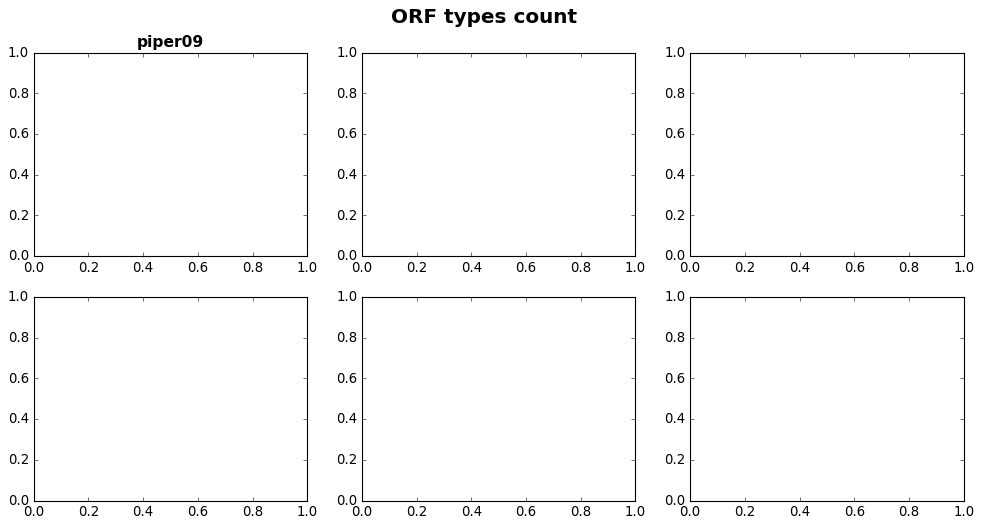

In [27]:
##### ORFs types #####
data = pd.DataFrame(index=['complete', 'internal', '5prime_partial', '3prime_partial'], dtype='float64') #empty dataframe

for species, proteome in proteome_list.items():
    transdecoder_count = proteome.loc[:, 'orf_type'].value_counts().rename(species)
    data = pd.concat([data, transdecoder_count], axis=1)


#plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 7)) #, 
fig.suptitle('ORF types count', fontsize=18, fontweight='bold')


axs = axs.flatten()
for n, (species, count) in enumerate(data.items()):
    ax = axs[n]
    ax.set_title(species, fontdict={'fontsize': '14', 'fontweight': 'bold'})
    ax.pie(count, labels=values.index, autopct='%1.1f%%', startangle=90)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

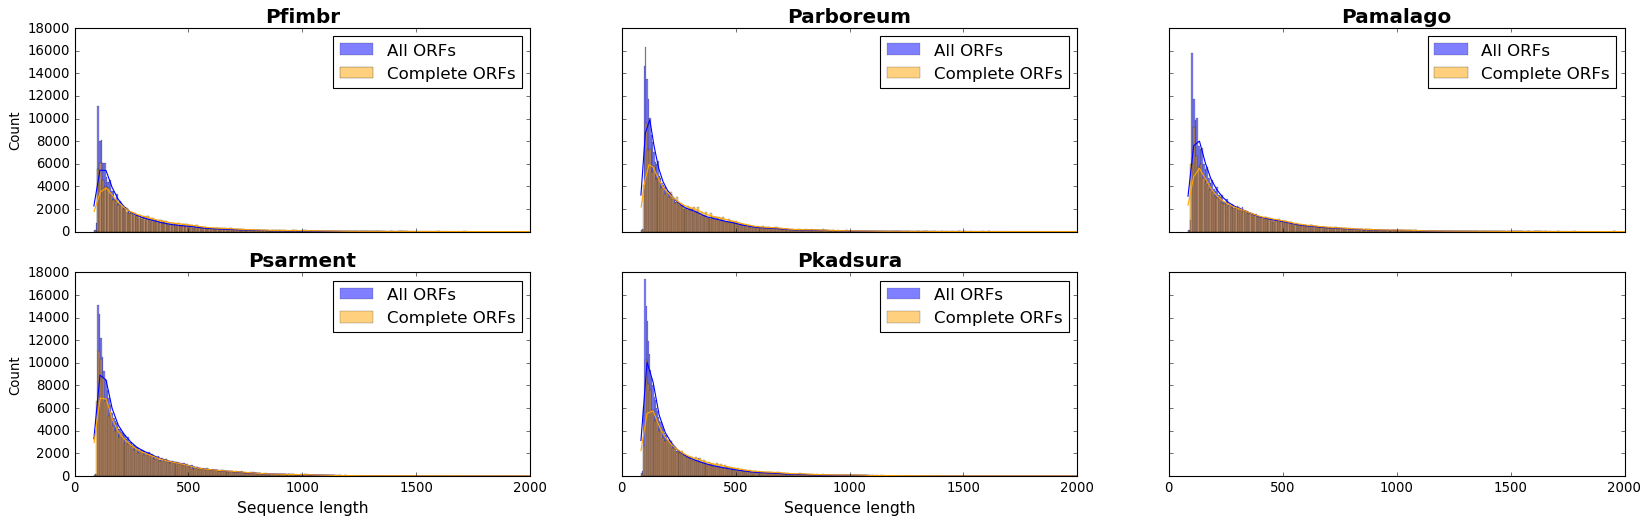

In [81]:
##### Proteine sequence lenght distribution #####

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 7), sharex=True, sharey=True)

axs = axs.flatten()
for n, (species, proteome) in enumerate(proteome_list.items()):
    axs[n].set_xlim(0, 2000) #set X-axis limits
    sns.histplot(proteome['length'], kde=True, ax=axs[n], label='All ORFs', color='blue')
    sns.histplot(proteome.loc[proteome['orf_type'] == 'complete']['length'], kde=True, ax=axs[n], label='Complete ORFs', color='orange')
    axs[n].legend(prop={'size': 15})
    axs[n].set_xlabel('Sequence length', fontdict={'fontsize': '14'})
    axs[n].set_title(species, fontdict={'fontsize': '18', 'fontweight': 'bold'})

#add Y-axis title
axs[0].set_ylabel('Count')

#show and save
plt.show()

In [6]:
proteome09.loc[proteome09['orf_type'] == 'complete']['length'].describe()

count    78395.000000
mean       307.686307
std        253.138048
min         86.000000
25%        141.000000
50%        221.000000
75%        385.000000
max       5397.000000
Name: length, dtype: float64

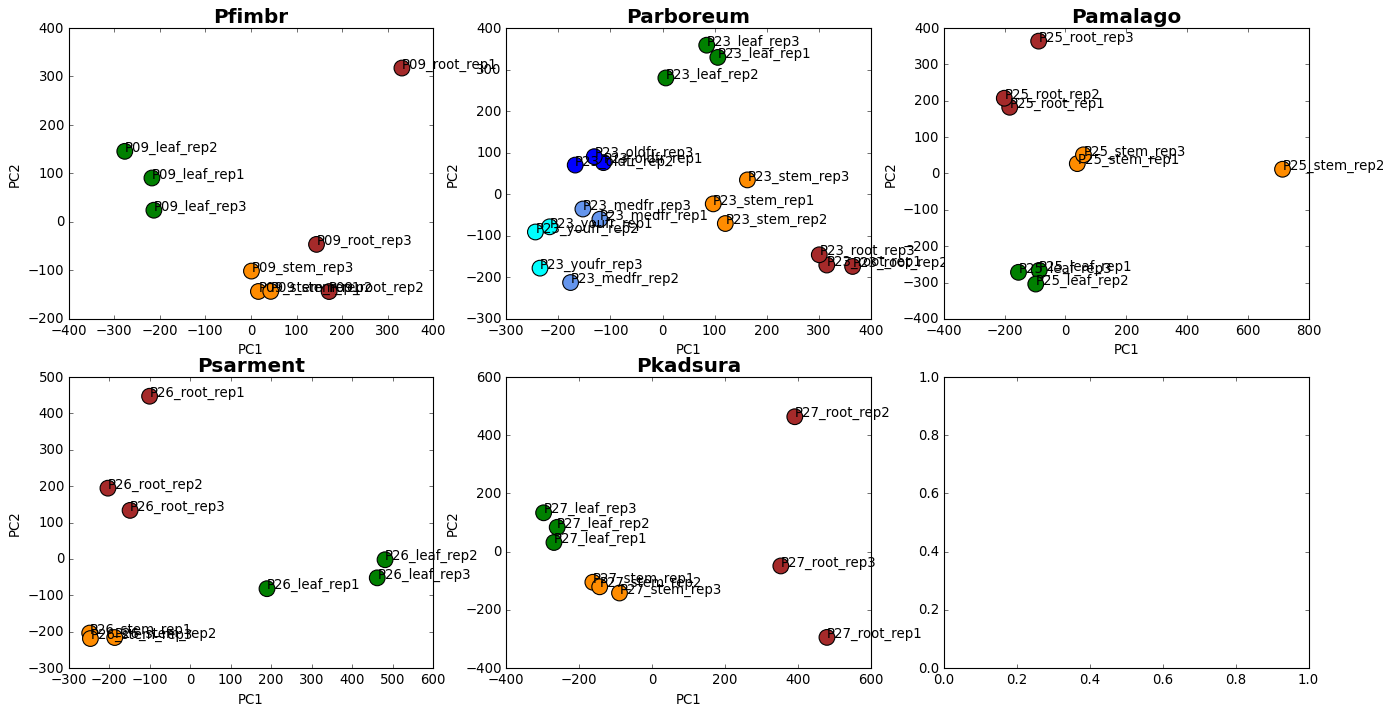

In [9]:
##### PCA #####
def tissue_to_color(item):
    cmap = {'leaf': 'green',
        'stem': 'darkorange',
        'root': 'brown',
        'youfr': 'cyan',
        'medfr': 'cornflowerblue',
        'oldfr': 'blue'}
    
    for key, color in cmap.items():
        if key in item:
            return color
    return None


#plot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axs = axs.flatten()

for n, (species, proteome) in enumerate(proteome_list.items()):
    proteome.index=proteome['protein_id']
    expr=proteome.loc[:, [col for col in proteome.columns if 'rep' in col]] #keep expression columns
    reps_map = {'leaf_rep': [col for col in expr.columns if 'leaf' in col],
        'medfr_rep': [col for col in expr.columns if 'medfr' in col],
        'oldfr_rep': [col for col in expr.columns if 'oldfr' in col],
        'root_rep': [col for col in expr.columns if 'root' in col],
        'stem_rep': [col for col in expr.columns if 'stem' in col],
        'youfr_rep': [col for col in expr.columns if 'youfr' in col]}
    
    reps_list = [item for sublist in reps_map.values() for item in sublist]

    #normalization
    data = expr.T
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    #pca
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data) #samples as rows 
    pca_result = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'], index=expr.columns)

    #create scatterplot
    ax = axs[n]
    colors = list(map(tissue_to_color, reps_list))
    ax.scatter(pca_result['PC1'], pca_result['PC2'], s=200, c=colors) #, c=colors[:len(pca_result)]
    ax.set_title(species, fontdict={'fontsize': '18', 'fontweight': 'bold'})
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    
    #annotate samplese
    for i, txt in enumerate(pca_result.index):
        ax.annotate(txt, (pca_result['PC1'][i], pca_result['PC2'][i]), fontsize=12)

plt.show()